In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [20]:
df.shape

(1599, 12)

In [21]:
#Seperating the dataset as response variable and feature variabes
X = df.drop ('quality',axis =1 )
y= df['quality']

In [22]:
#Applying Standard scaling to get optimized result
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [23]:
X_scale

array([[0.24778761, 0.39726027, 0.        , ..., 0.60629921, 0.13772455,
        0.15384615],
       [0.28318584, 0.52054795, 0.        , ..., 0.36220472, 0.20958084,
        0.21538462],
       [0.28318584, 0.43835616, 0.04      , ..., 0.40944882, 0.19161677,
        0.21538462],
       ...,
       [0.15044248, 0.26712329, 0.13      , ..., 0.53543307, 0.25149701,
        0.4       ],
       [0.11504425, 0.35958904, 0.12      , ..., 0.65354331, 0.22754491,
        0.27692308],
       [0.12389381, 0.13013699, 0.47      , ..., 0.51181102, 0.19760479,
        0.4       ]])

In [24]:
#Train and Test splitting of data into 80-20 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
import tensorflow as tf

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

In [50]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=['accuracy']
)

In [52]:
hist_1 = model.fit(
    X_train, y_train,
    batch_size = 128,
    epochs = 200,
    validation_data=(X_test, y_test)
)

Epoch 1/200

10/10 [==============================] - 1s 29ms/step - loss: 2.6997 - accuracy: 0.0000e+00 - val_loss: 1.2901 - val_accuracy: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 0s 7ms/step - loss: 0.8690 - accuracy: 0.0000e+00 - val_loss: 0.7179 - val_accuracy: 0.0000e+00
Epoch 3/200
10/10 [==============================] - 0s 6ms/step - loss: 0.7370 - accuracy: 0.0000e+00 - val_loss: 0.6346 - val_accuracy: 0.0000e+00
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.7219 - accuracy: 0.0000e+00 - val_loss: 0.6811 - val_accuracy: 0.0000e+00
Epoch 5/200
10/10 [==============================] - 0s 7ms/step - loss: 0.6167 - accuracy: 0.0000e+00 - val_loss: 0.5876 - val_accuracy: 0.0000e+00
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 0.6310 - accuracy: 0.0000e+00 - val_loss: 0.5798 - val_accuracy: 0.0000e+00
Epoch 7/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6463 - accuracy: 0.0000e+00 -

In [53]:
accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.4924 - accuracy: 0.0000e+00
Test Accuracy: [0.49244505167007446, 0.0]


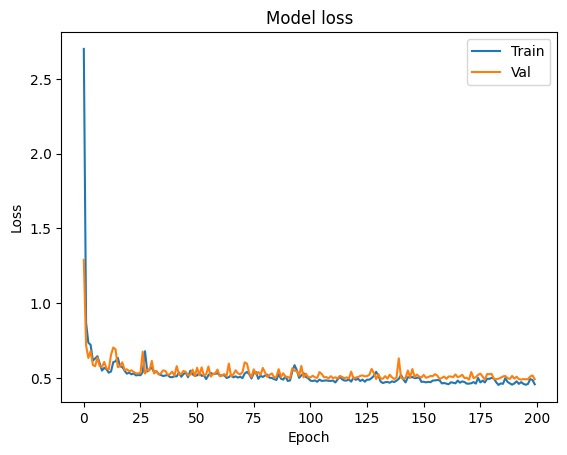

In [54]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

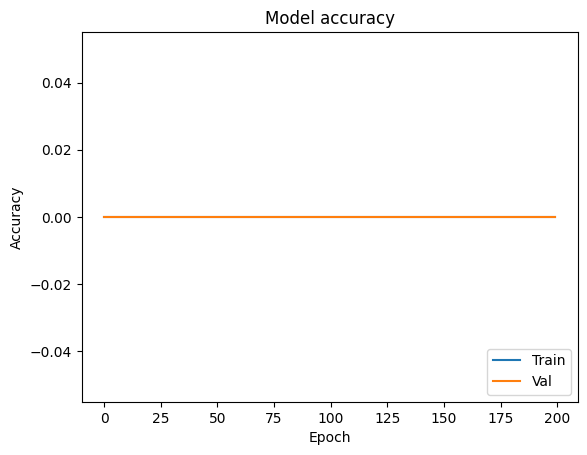

In [55]:
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()